In [1]:
from src.model import VAE
from src.trainer import CDVAETrainer
from src.model import interpolate_latent
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%load_ext autoreload
%autoreload 2

In [2]:
from corruption_utils import corruptions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [5]:
from src.utils import CMNISTGenerator, CMNIST

In [6]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11, device=device)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate style:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11, device=device)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate content:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()


In [7]:
generator = CMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.3,
        corruptions.stripe: 0.2,
        corruptions.zigzag: 0.3,
        corruptions.canny_edges: 0.1,
        corruptions.brightness: 0.1
    },
)


In [8]:
dataset = CMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

test, train = random_split(dataset, [32, len(dataset) - 32])
valid, train = random_split(train, [10000, len(train) - 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:13<00:00, 4411.24item/s]


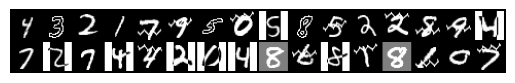

In [9]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)


X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


In [10]:
X.shape

torch.Size([32, 1, 28, 28])

### cosine sim + label-flipping

In [11]:
Z_DIM = 16
TEMP = 0.3
ALPHA = [100, 100]
LABEL_FLIPPING = True

In [12]:
vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 0.5, "loc": 5e3, "scale": 1e3,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [13]:
next(iter(dataloader))[0].shape

torch.Size([128, 1, 28, 28])

In [47]:
trainer.fit(51, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 169.40it/s]


val_recontr_loss=62.217, val_kl_c=4.089, val_kl_s=12.754, val_c_loss=0.511, val_s_loss=0.107
gMIG: 0.349


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 176.79it/s]


val_recontr_loss=29.410, val_kl_c=3.710, val_kl_s=8.777, val_c_loss=0.351, val_s_loss=0.107
gMIG: 0.446


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 173.54it/s]


val_recontr_loss=23.992, val_kl_c=3.161, val_kl_s=4.602, val_c_loss=0.336, val_s_loss=0.109
gMIG: 0.466


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 177.21it/s]


val_recontr_loss=22.241, val_kl_c=2.784, val_kl_s=3.441, val_c_loss=0.328, val_s_loss=0.109
gMIG: 0.485


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 176.96it/s]


val_recontr_loss=21.244, val_kl_c=2.658, val_kl_s=3.172, val_c_loss=0.331, val_s_loss=0.109
gMIG: 0.49


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 169.68it/s]


val_recontr_loss=20.267, val_kl_c=2.643, val_kl_s=3.196, val_c_loss=0.324, val_s_loss=0.109
gMIG: 0.494


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 167.79it/s]


val_recontr_loss=19.624, val_kl_c=2.697, val_kl_s=3.091, val_c_loss=0.321, val_s_loss=0.109
gMIG: 0.503


val-epoch 35: 100%|██████████| 79/79 [00:00<00:00, 171.82it/s]


val_recontr_loss=18.975, val_kl_c=2.796, val_kl_s=3.225, val_c_loss=0.319, val_s_loss=0.109
gMIG: 0.501


val-epoch 40: 100%|██████████| 79/79 [00:00<00:00, 169.15it/s]


val_recontr_loss=18.599, val_kl_c=2.782, val_kl_s=3.182, val_c_loss=0.317, val_s_loss=0.109
gMIG: 0.504


val-epoch 45: 100%|██████████| 79/79 [00:00<00:00, 170.76it/s]


val_recontr_loss=17.991, val_kl_c=2.867, val_kl_s=3.347, val_c_loss=0.317, val_s_loss=0.109
gMIG: 0.514


val-epoch 50: 100%|██████████| 79/79 [00:00<00:00, 179.96it/s]


val_recontr_loss=17.757, val_kl_c=2.900, val_kl_s=3.224, val_c_loss=0.319, val_s_loss=0.108
gMIG: 0.517


In [38]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)

interpolate style:


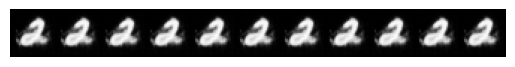

interpolate content:


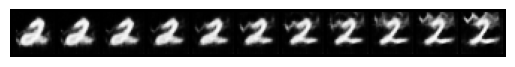

In [39]:
display_util(9, 16, z, vae, 16)

interpolate style:


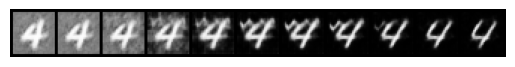

interpolate content:


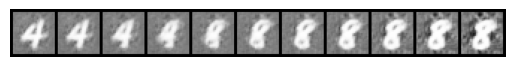

In [40]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

interpolate style:


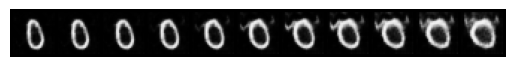

interpolate content:


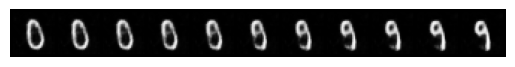

In [41]:
display_util(17, 14, z, vae, int(Z_DIM / 2))

interpolate style:


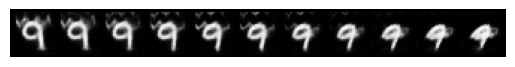

interpolate content:


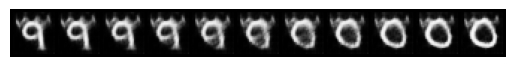

In [42]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

interpolate style:


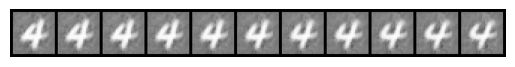

interpolate content:


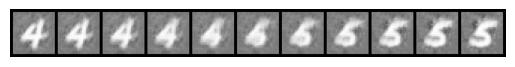

In [43]:
display_util(1, 31, z, vae, int(Z_DIM / 2))

In [48]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)


100%|██████████| 79/79 [00:00<00:00, 297.22it/s]


In [49]:
mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)

In [50]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

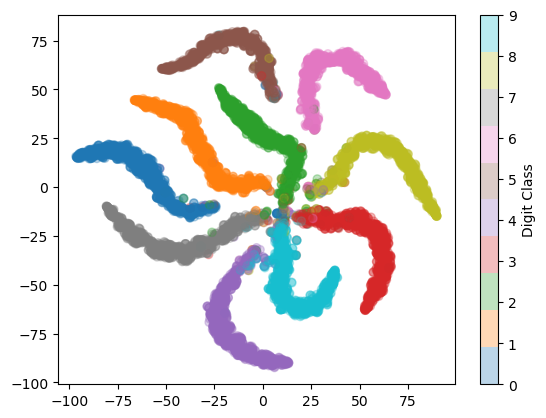

In [51]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

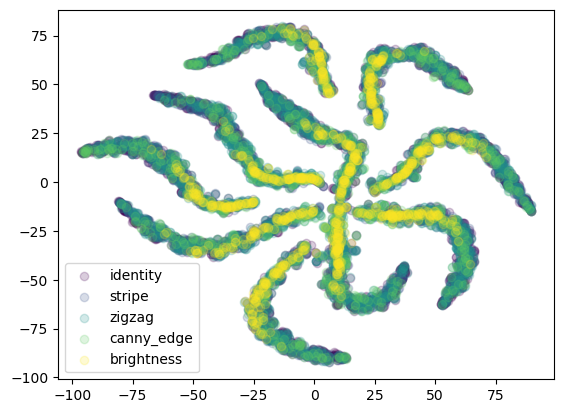

In [52]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [53]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

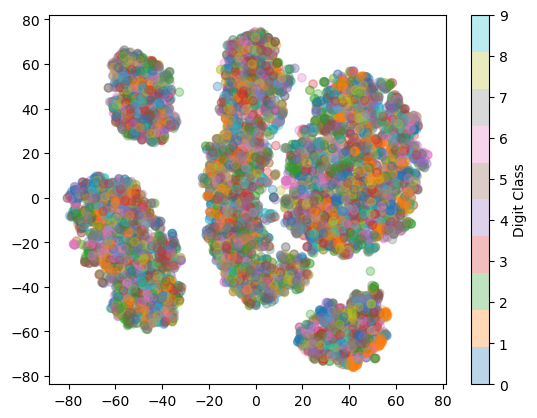

In [54]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

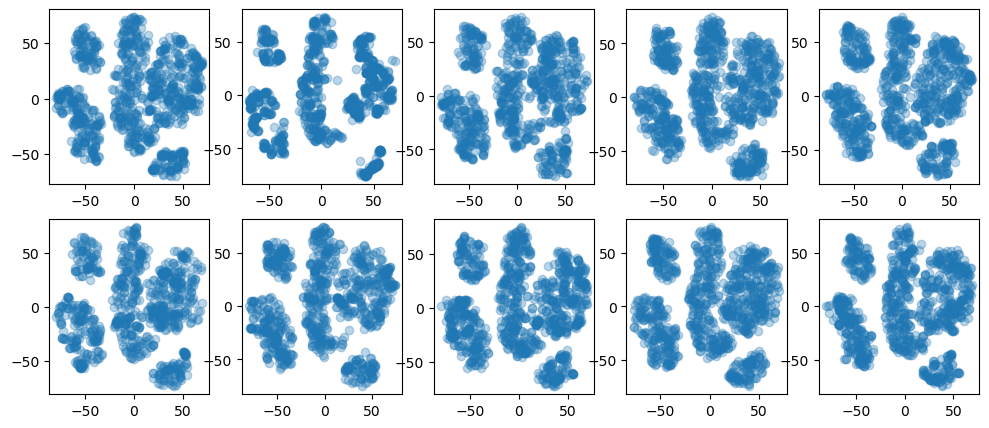

In [55]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

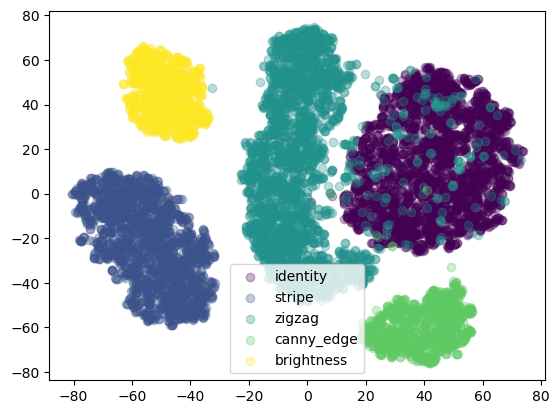

In [56]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

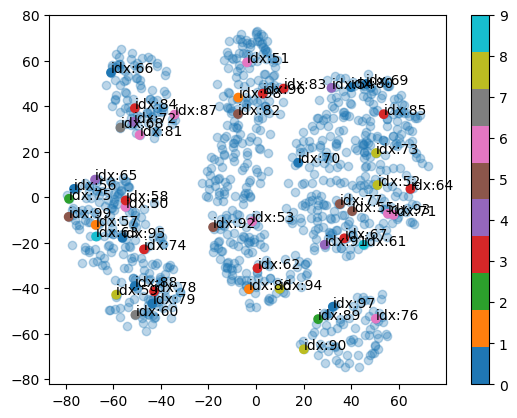

In [57]:
idxs = list(range(50, 100))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [58]:
idx = 8
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [59]:
for i in [53, 88, 62, 67, 73, 85, 79, 98, 68]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))

### cosine sim + (-L)

In [31]:
Z_DIM = 16
TEMP = 0.5
ALPHA = [500, 500]
LABEL_FLIPPING = False

In [32]:
vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1, "loc": 5e3, "scale": 1e3,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=3,
    device=device,
)

In [33]:
trainer.fit(40, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 180.78it/s]


val_recontr_loss=54.548, val_kl_c=4.289, val_kl_s=13.355, val_c_loss=0.932, val_s_loss=-2.380
gMIG: 0.395


val-epoch 3: 100%|██████████| 79/79 [00:00<00:00, 213.31it/s]


val_recontr_loss=30.677, val_kl_c=4.624, val_kl_s=16.631, val_c_loss=0.844, val_s_loss=-2.380
gMIG: 0.454


val-epoch 6: 100%|██████████| 79/79 [00:00<00:00, 175.84it/s]


val_recontr_loss=28.236, val_kl_c=4.621, val_kl_s=11.009, val_c_loss=0.813, val_s_loss=-2.380
gMIG: 0.483


val-epoch 9: 100%|██████████| 79/79 [00:00<00:00, 181.75it/s]


val_recontr_loss=26.361, val_kl_c=3.681, val_kl_s=6.779, val_c_loss=0.799, val_s_loss=-2.379
gMIG: 0.485


val-epoch 12: 100%|██████████| 79/79 [00:00<00:00, 170.23it/s]


val_recontr_loss=26.439, val_kl_c=2.626, val_kl_s=4.552, val_c_loss=0.800, val_s_loss=-2.379
gMIG: 0.483


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 179.61it/s]


val_recontr_loss=26.599, val_kl_c=2.117, val_kl_s=3.784, val_c_loss=0.794, val_s_loss=-2.379
gMIG: 0.486


val-epoch 18: 100%|██████████| 79/79 [00:00<00:00, 181.91it/s]


val_recontr_loss=25.585, val_kl_c=1.884, val_kl_s=3.766, val_c_loss=0.790, val_s_loss=-2.379
gMIG: 0.489


val-epoch 21: 100%|██████████| 79/79 [00:00<00:00, 183.28it/s]


val_recontr_loss=25.558, val_kl_c=1.789, val_kl_s=3.845, val_c_loss=0.791, val_s_loss=-2.380
gMIG: 0.484


val-epoch 24: 100%|██████████| 79/79 [00:00<00:00, 179.28it/s]


val_recontr_loss=25.609, val_kl_c=1.825, val_kl_s=3.806, val_c_loss=0.808, val_s_loss=-2.379
gMIG: 0.464


val-epoch 27: 100%|██████████| 79/79 [00:00<00:00, 178.41it/s]


val_recontr_loss=24.832, val_kl_c=1.610, val_kl_s=3.638, val_c_loss=0.792, val_s_loss=-2.379
gMIG: 0.478


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 182.71it/s]


val_recontr_loss=24.578, val_kl_c=1.607, val_kl_s=3.753, val_c_loss=0.787, val_s_loss=-2.380
gMIG: 0.474


val-epoch 33: 100%|██████████| 79/79 [00:00<00:00, 185.87it/s]


val_recontr_loss=24.134, val_kl_c=1.550, val_kl_s=3.746, val_c_loss=0.797, val_s_loss=-2.380
gMIG: 0.468


val-epoch 36: 100%|██████████| 79/79 [00:00<00:00, 184.12it/s]


val_recontr_loss=23.735, val_kl_c=1.583, val_kl_s=3.891, val_c_loss=0.790, val_s_loss=-2.380
gMIG: 0.472


val-epoch 39: 100%|██████████| 79/79 [00:00<00:00, 187.80it/s]


val_recontr_loss=23.363, val_kl_c=1.549, val_kl_s=3.841, val_c_loss=0.787, val_s_loss=-2.380
gMIG: 0.482


In [34]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)

interpolate style:


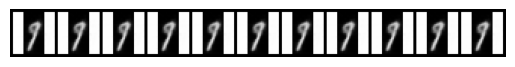

interpolate content:


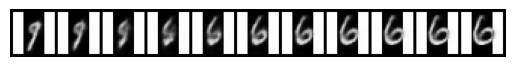

In [35]:
display_util(9, 16, z, vae, 16)

interpolate style:


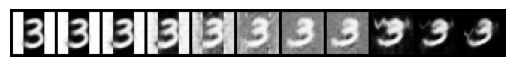

interpolate content:


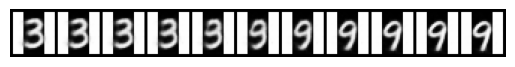

In [36]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

interpolate style:


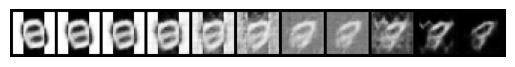

interpolate content:


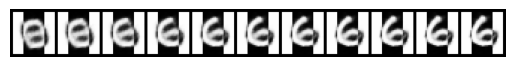

In [37]:
display_util(17, 14, z, vae, int(Z_DIM / 2))

interpolate style:


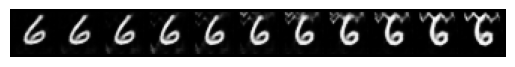

interpolate content:


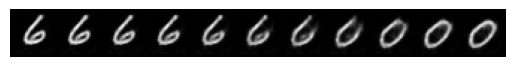

In [38]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

interpolate style:


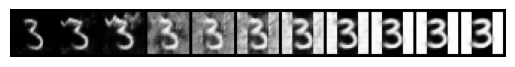

interpolate content:


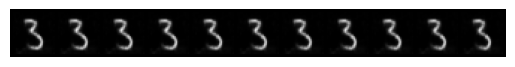

In [39]:
display_util(31, 1, z, vae, int(Z_DIM / 2))

In [40]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)

100%|██████████| 79/79 [00:00<00:00, 291.88it/s]


In [41]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

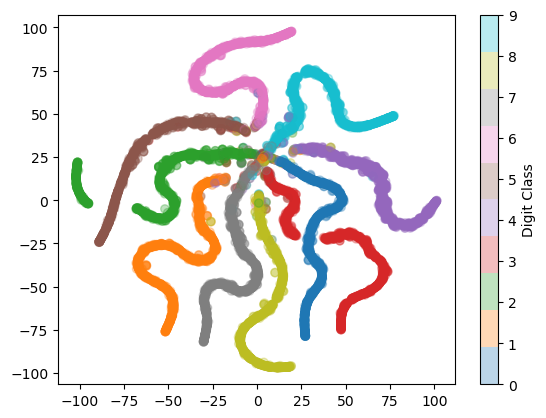

In [42]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

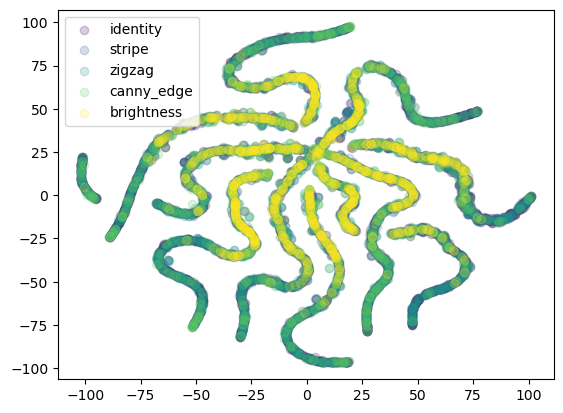

In [43]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [44]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

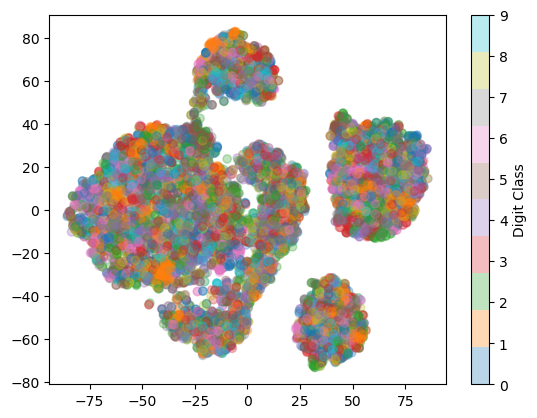

In [45]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

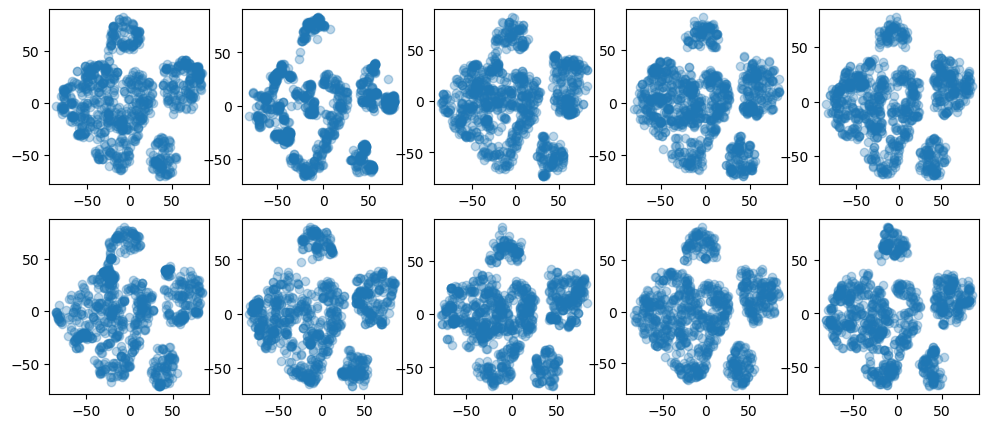

In [46]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

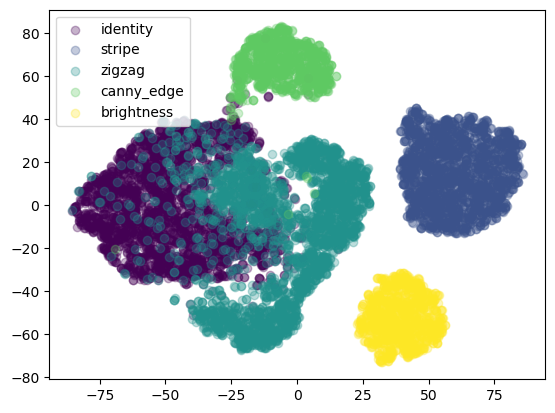

In [47]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

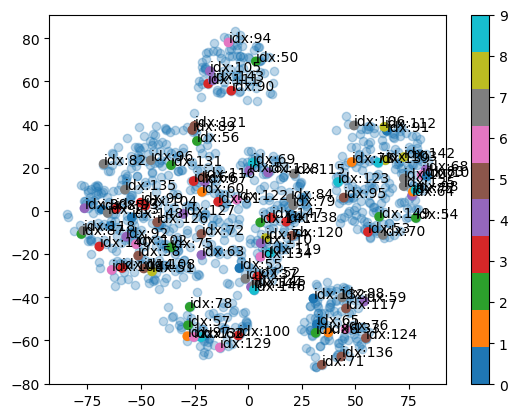

In [48]:
idxs = list(range(50, 150))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [49]:
idx = 8
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [50]:
for i in [53, 88, 62, 67, 73, 85, 79, 98, 68]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))